
# Bayesian Multivariate Regression: Tap Rate & CV–ITI (PyMC v5)

This notebook estimates a **joint Bayesian multivariate model** for:
- **Interaction frequency**: `tap_rate_z`
- **Interaction regularity**: `cv_iti_z`

Predictors: `orientation_entropy_z`, `degree_mean_z`, `circuity_log_z`, `SA_z`, `SBSOD_z`, `Gender_M` (centered).  
Outputs are written to `notebooks/outputs/bayesmv/`.


In [1]:

# Imports
import os
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler

import pymc as pm
import pytensor.tensor as at
import arviz as az

# Repro
np.random.seed(42)

# Paths (this notebook lives in notebooks/)
DATA_PATH = Path("../data/pre-processed_anonimized_final_clean.csv")
OUT_DIR = Path("outputs") / "bayesmv"
(OUT_DIR / "figs").mkdir(parents=True, exist_ok=True)
(OUT_DIR / "summaries").mkdir(parents=True, exist_ok=True)

print(f"Python: {os.sys.version.split()[0]}")
print("PyMC:", pm.__version__, "| ArviZ:", az.__version__)
print("Data path:", DATA_PATH.resolve() if DATA_PATH.exists() else DATA_PATH)
print("Outputs →", OUT_DIR.resolve())


Python: 3.11.14
PyMC: 5.26.1 | ArviZ: 0.22.0
Data path: /Users/donatellazingaro/TSAS_Special_Issue_Urban_Mobility/data/pre-processed_anonimized_final_clean.csv
Outputs → /Users/donatellazingaro/TSAS_Special_Issue_Urban_Mobility/notebooks/outputs/bayesmv


In [2]:

# Load dataset
df = pd.read_csv(DATA_PATH)

# Create Gender_M if needed
if "Gender_M" not in df.columns and "Gender" in df.columns:
    df["Gender_M"] = (df["Gender"].astype(str).str.upper().str[0] == "M").astype(float)

# Standardize SA_Score and SBDS_score into SA_z and SBSOD_z if needed
if "SA_z" not in df.columns or "SBSOD_z" not in df.columns:
    needed = {"SA_Score", "SBDS_score"}
    if needed.issubset(df.columns):
        scaler = StandardScaler()
        df[["SA_z", "SBSOD_z"]] = scaler.fit_transform(df[["SA_Score", "SBDS_score"]])
        print("✅ Standardized SA_Score & SBDS_score → SA_z, SBSOD_z")
    else:
        raise ValueError("Required columns for standardization not found: SA_Score, SBDS_score")

predictors = [
    "orientation_entropy_z",
    "degree_mean_z",
    "circuity_log_z",
    "SA_z",
    "SBSOD_z",
    "Gender_M",
]

required = predictors + ["tap_rate_z", "cv_iti_z", "partId"]
missing = [c for c in required if c not in df.columns]
if missing:
    raise ValueError(f"Missing columns needed for Bayesian model: {missing}\nPresent: {list(df.columns)}")

# Complete cases only
mask = df[required].notna().all(axis=1)
df_clean = df.loc[mask, required].reset_index(drop=True)

# Center Gender_M
df_clean["Gender_M"] = df_clean["Gender_M"].astype(float) - df_clean["Gender_M"].astype(float).mean()

print(f"✅ Data ready | Sessions: {len(df_clean)} | Participants: {df_clean['partId'].nunique()}")
df_clean.head(3)


✅ Standardized SA_Score & SBDS_score → SA_z, SBSOD_z
✅ Data ready | Sessions: 2399 | Participants: 46


,orientation_entropy_z,degree_mean_z,circuity_log_z,SA_z,SBSOD_z,Gender_M,tap_rate_z,cv_iti_z,partId
0,0.897173,0.182502,-0.031681,-1.172893,0.292713,0.298875,-0.879134,-0.519456,P001
1,-0.167296,0.196367,-0.436893,-1.172893,0.292713,0.298875,-0.047426,-0.338614,P001
2,0.333384,0.314307,0.276742,-1.172893,0.292713,0.298875,0.047692,-0.140514,P001


In [3]:

# Build design matrices
Y = df_clean[["tap_rate_z", "cv_iti_z"]].to_numpy(dtype="float64")
X = df_clean[predictors].to_numpy(dtype="float64")

n_obs, n_pred = X.shape
n_out = Y.shape[1]
print("Shapes → X:", X.shape, "Y:", Y.shape, "| preds:", n_pred, "| outs:", n_out)


Shapes → X: (2399, 6) Y: (2399, 2) | preds: 6 | outs: 2


In [4]:

with pm.Model() as mv_model:
    # Intercepts
    alpha = pm.Normal("alpha", mu=0.0, sigma=0.5, shape=(n_out,))

    # Coefficients (predictors × outcomes)
    B = pm.Normal("B", mu=0.0, sigma=0.5, shape=(n_pred, n_out))

    # LKJ prior on residual covariance
    L, corr, sigmas = pm.LKJCholeskyCov(
        "L",
        n=n_out,
        eta=2.0,
        sd_dist=pm.HalfNormal.dist(0.5)
    )
    Sigma = pm.Deterministic("Sigma", L @ L.T)

    # Mean matrix
    mu = alpha + at.dot(X, B)

    # Likelihood
    y_like = pm.MvNormal("y_like", mu=mu, chol=L, observed=Y)

    trace = pm.sample(
        draws=1500,
        tune=1500,
        chains=4,
        cores=1,          # stable on macOS/VS Code
        init="adapt_diag",
        target_accept=0.95,
        random_seed=42
    )

# Save trace
az.to_netcdf(trace, OUT_DIR / "trace_bayesmv.nc")
trace


Initializing NUTS using adapt_diag...
Sequential sampling (4 chains in 1 job)
NUTS: [alpha, B, L]


/opt/anaconda3/envs/tsas_env/lib/python3.11/site-packages/rich/live.py:256: UserWarning: install "ipywidgets" for 
Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

/opt/anaconda3/envs/tsas_env/lib/python3.11/site-packages/rich/live.py:256: UserWarning: install "ipywidgets" for 
Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

/opt/anaconda3/envs/tsas_env/lib/python3.11/site-packages/rich/live.py:256: UserWarning: install "ipywidgets" for 
Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

/opt/anaconda3/envs/tsas_env/lib/python3.11/site-packages/rich/live.py:256: UserWarning: install "ipywidgets" for 
Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Sampling 4 chains for 1_500 tune and 1_500 draw iterations (6_000 + 6_000 draws total) took 41 seconds.


Inference data with groups:
	> posterior
	> sample_stats
	> observed_data

In [5]:

summary = az.summary(trace, var_names=["alpha","B","Sigma"], round_to=3)
summary_path = OUT_DIR / "summaries" / "posterior_summary.csv"
summary.to_csv(summary_path, index=True)
print(summary)
print("Saved summary →", summary_path)

# Residual correlation rho between tap_rate_z and cv_iti_z
Sigma_samps = trace.posterior["Sigma"].stack(s=("chain","draw")).values
cov_xy = Sigma_samps[0,1,:]
var_x  = Sigma_samps[0,0,:]
var_y  = Sigma_samps[1,1,:]
rho = cov_xy / np.sqrt(var_x * var_y)

rho_mean = float(rho.mean())
rho_ci = (float(np.percentile(rho, 2.5)), float(np.percentile(rho, 97.5)))

with open(OUT_DIR / "summaries" / "residual_correlation.txt", "w") as f:
    f.write("Residual correlation (tap_rate_z, cv_iti_z)\n")
    f.write(f"Posterior mean ρ = {rho_mean:.3f}\n")
    f.write(f"95% CrI = [{rho_ci[0]:.3f}, {rho_ci[1]:.3f}]\n")

print(f"\nResidual correlation Posterior mean ρ = {rho_mean:.3f}")
print(f"95% CrI: [{rho_ci[0]:.3f}, {rho_ci[1]:.3f}]")


              mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd   ess_bulk  \
alpha[0]     0.010  0.020  -0.027    0.048      0.000    0.000   7252.213   
alpha[1]    -0.015  0.020  -0.051    0.024      0.000    0.000   7841.641   
B[0, 0]     -0.053  0.024  -0.096   -0.007      0.000    0.000   7198.930   
B[0, 1]      0.093  0.023   0.047    0.134      0.000    0.000   5905.656   
B[1, 0]     -0.080  0.024  -0.126   -0.039      0.000    0.000   7122.885   
B[1, 1]      0.025  0.024  -0.018    0.069      0.000    0.000   6420.328   
B[2, 0]     -0.036  0.020  -0.073    0.002      0.000    0.000   8994.306   
B[2, 1]      0.012  0.020  -0.025    0.049      0.000    0.000   8863.593   
B[3, 0]     -0.164  0.021  -0.201   -0.123      0.000    0.000   7879.398   
B[3, 1]      0.144  0.021   0.107    0.184      0.000    0.000   7013.552   
B[4, 0]     -0.010  0.021  -0.051    0.028      0.000    0.000   7085.210   
B[4, 1]      0.036  0.021  -0.005    0.075      0.000    0.000   8035.360   

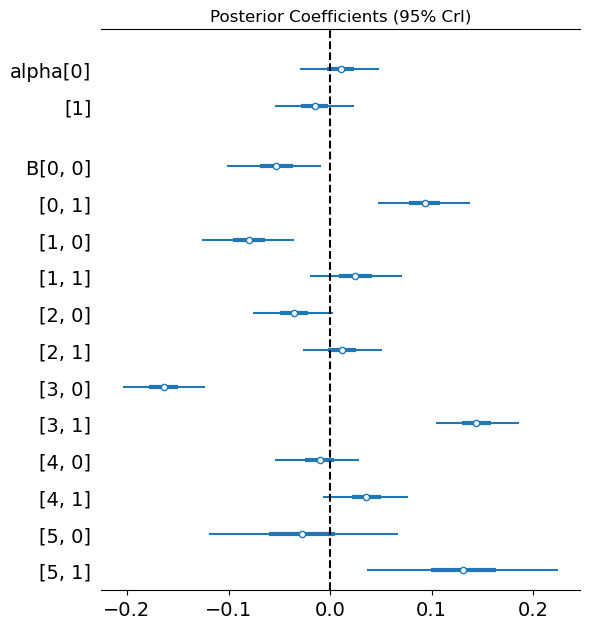

Saved → outputs/bayesmv/figs/forest_coefficients.png


In [6]:

fig = az.plot_forest(trace, var_names=["alpha","B"], combined=True, hdi_prob=0.95)
plt.axvline(0, ls="--", c="black")
plt.title("Posterior Coefficients (95% CrI)")
plt.tight_layout()
fig_path = OUT_DIR / "figs" / "forest_coefficients.png"
plt.savefig(fig_path, dpi=300, bbox_inches="tight")
plt.show()
print("Saved →", fig_path)


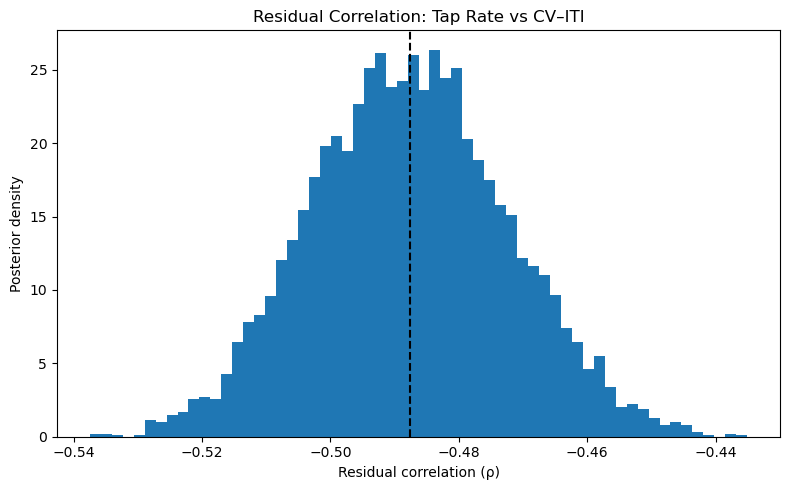

Saved → outputs/bayesmv/figs/rho_posterior.png


In [7]:

plt.figure(figsize=(8,5))
plt.hist(rho, bins=60, density=True)
plt.axvline(rho_mean, ls="--", c="black")
plt.xlabel("Residual correlation (ρ)")
plt.ylabel("Posterior density")
plt.title("Residual Correlation: Tap Rate vs CV–ITI")
plt.tight_layout()
rho_path = OUT_DIR / "figs" / "rho_posterior.png"
plt.savefig(rho_path, dpi=300, bbox_inches="tight")
plt.show()
print("Saved →", rho_path)
